In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('profiles_data_20132023.csv')

In [6]:
## Filtering to keep only neighborhoods
neigh = df[df["GeographyType"] == "neighborhood"].copy()
print("Neighborhood rows:", neigh.shape)

def minmax(series):
    return (series - series.min()) / (series.max() - series.min())

Neighborhood rows: (66, 417)


In [7]:
## SUBMETRIC 1: MEDIAN HOUSEHOLD INCOME IMPROVEMENT
income_2013 = [
    "Var_2013_income_Per_2","Var_2013_income_Per_3","Var_2013_income_Per_4",
    "Var_2013_income_Per_5","Var_2013_income_Per_6","Var_2013_income_Per_7"
]

income_2023 = [
    "Var_2023_income_Per_2","Var_2023_income_Per_3","Var_2023_income_Per_4",
    "Var_2023_income_Per_5","Var_2023_income_Per_6","Var_2023_income_Per_7"
]

weights = {
    "Per_2": 1,
    "Per_3": 2,
    "Per_4": 3,
    "Per_5": 4,
    "Per_6": 5,
    "Per_7": 6,
}

neigh["income_index_2013"] = 0
neigh["income_index_2023"] = 0

for i, col_13 in enumerate(income_2013):
    w = weights[f"Per_{i+2}"]
    neigh["income_index_2013"] += neigh[col_13] * w

for i, col_23 in enumerate(income_2023):
    w = weights[f"Per_{i+2}"]
    neigh["income_index_2023"] += neigh[col_23] * w

## Improvement 1
neigh["income_improvement"] = neigh["income_index_2023"] - neigh["income_index_2013"]

In [8]:
## SUBMETRIC 2: POVERTY RATE IMPROVEMENT
poverty_2013 = neigh["Var_2013_poverty_Per_2"] + neigh["Var_2013_poverty_Per_3"]
poverty_2023 = neigh["Var_2023_poverty_Per_2"] + neigh["Var_2023_poverty_Per_3"]

## Improvement 2
neigh["poverty_drop"] = poverty_2013 - poverty_2023  # drop = improvement

In [9]:
## SUBMETRIC 3: OWNER OCCUPANCY IMPROVEMENT
neigh["owner_occ_2013"] = neigh["Var_2013_tenure_Per_2"]
neigh["owner_occ_2023"] = neigh["Var_2023_tenure_Per_2"]

## Improvement 3
neigh["owner_occ_improvement"] = (
    neigh["owner_occ_2023"] - neigh["owner_occ_2013"]
)

In [10]:
## SUBMETRIC 4: POPULATION CHANGE

## Improvement 4
neigh["population_improvement"] = neigh["Var_ChangePer_TotalPopulation"]

In [11]:
## SUBMETRIC 5: % Bachelor’s Degree or Higher IMPROVEMENT
neigh["ba_2013"] = neigh["Var_2013_educ_Per_5"]
neigh["ba_2023"] = neigh["Var_2023_educ_Per_5"]

## Improvement 5
neigh["ba_improvement"] = neigh["ba_2023"] - neigh["ba_2013"]


In [12]:
## SUBMETRIC 6: RENT BURDEN IMPROVEMENT
## used: rent_burden = renter_share * low_income_share
## Lower burden = improvement

## 2013
renter_2013 = 1 - neigh["Var_2013_tenure_Per_2"]
lowinc_2013 = neigh["Var_2013_income_Per_2"] + neigh["Var_2013_income_Per_3"]

## 2023
renter_2023 = 1 - neigh["Var_2023_tenure_Per_2"]
lowinc_2023 = neigh["Var_2023_income_Per_2"] + neigh["Var_2023_income_Per_3"]

neigh["rent_burden_2013"] = renter_2013 * lowinc_2013
neigh["rent_burden_2023"] = renter_2023 * lowinc_2023

## Improvement 6
neigh["rent_burden_improvement"] = (
    neigh["rent_burden_2013"] - neigh["rent_burden_2023"]
)

In [13]:
## SUBMETRIC 7: % Households with Children IMPROVEMENT
neigh["children_2013"] = neigh["Var_2013_hhtype_Per_5"] + neigh["Var_2013_hhtype_Per_6"]
neigh["children_2023"] = neigh["Var_2023_hhtype_Per_5"] + neigh["Var_2023_hhtype_Per_6"]

## Improvement 7
neigh["children_improvement"] = (
    neigh["children_2023"] - neigh["children_2013"]
)

In [14]:
## Normalizing all improvements 0–1 (higher = better)
improve_cols = [
    "income_improvement",
    "poverty_drop",
    "owner_occ_improvement",
    "population_improvement",
    "ba_improvement",
    "rent_burden_improvement",
    "children_improvement",
]

for col in improve_cols:
    neigh[col + "_score"] = minmax(neigh[col])



## OVERALL IMPROVEMENT SCORE
score_cols = [c + "_score" for c in improve_cols]
neigh["overall_improvement"] = neigh[score_cols].mean(axis=1)
ranking = neigh[["AreaName", "overall_improvement"] + score_cols]\
    .sort_values("overall_improvement", ascending=False)\
    .reset_index(drop=True)
print("TOP 15 Most Improved Neighborhoods (2013 → 2023):")
display(ranking.head(15))
print("\nBOTTOM 10 Least Improved Neighborhoods:")
display(ranking.tail(10))


TOP 15 Most Improved Neighborhoods (2013 → 2023):


,AreaName,overall_improvement,income_improvement_score,poverty_drop_score,owner_occ_improvement_score,population_improvement_score,ba_improvement_score,rent_burden_improvement_score,children_improvement_score
0,South Shore,0.667760,0.729982,0.424080,0.717179,1.000000,1.000000,0.008934,0.794145
1,Allegheny Center - Allegheny West,0.624044,0.874358,0.876820,0.607004,0.100227,0.416329,0.896886,0.596682
2,East Liberty,0.591881,0.772400,0.833939,0.929453,0.037061,0.427186,1.000000,0.143127
3,Lower Lawrenceville,0.585764,1.000000,0.765276,0.865621,0.032117,0.614393,0.822944,0.000000
4,Upper Lawrenceville,0.537276,0.952670,0.676956,0.678372,0.016194,0.510368,0.605354,0.321021
5,Garfield,0.536076,0.855977,0.819213,0.708435,0.036964,0.489074,0.790513,0.052357
6,Point Breeze North,0.522788,0.749408,0.690548,0.632091,0.044509,0.268815,0.625091,0.649055
7,Fineview,0.505707,0.623026,0.546327,0.872099,0.033691,0.271091,0.645806,0.547906
8,Westwood - Ridgemont,0.499309,0.538127,0.782817,0.818222,0.025525,0.232941,0.513928,0.583603
9,Friendship,0.499022,0.567425,0.696719,0.723848,0.079369,0.236635,0.670621,0.518534



BOTTOM 10 Least Improved Neighborhoods:


,AreaName,overall_improvement,income_improvement_score,poverty_drop_score,owner_occ_improvement_score,population_improvement_score,ba_improvement_score,rent_burden_improvement_score,children_improvement_score
56,Crafton Heights,0.332531,0.158534,0.518710,0.625676,0.045223,0.107418,0.314883,0.557272
57,Beltzhoover - Bon Air,0.329053,0.175876,0.254556,0.503884,0.040882,0.220694,0.209467,0.898016
58,Perry North,0.324159,0.438431,0.554504,0.527168,0.027403,0.061740,0.395202,0.264663
59,Marshall-Shadeland,0.318154,0.217287,0.454506,0.403972,0.000000,0.228945,0.204602,0.717762
60,Terrace Village - West Oakland,0.296605,0.187700,0.245472,0.675332,0.041467,0.126361,0.480133,0.319766
61,Middle Hill,0.281524,0.050642,0.000000,0.558866,0.037448,0.125222,0.268654,0.929833
62,Central Oakland,0.263251,0.081783,0.426548,0.649410,0.024523,0.000000,0.264665,0.395828
63,East Hills,0.239882,0.140319,0.233390,0.385669,0.055968,0.091439,0.116684,0.655700
64,South Oakland,0.183327,0.023330,0.149875,0.309825,0.059759,0.271363,0.030126,0.439008
65,Bluff,0.160242,0.146105,0.421604,0.000000,0.046021,0.127816,0.000000,0.380149


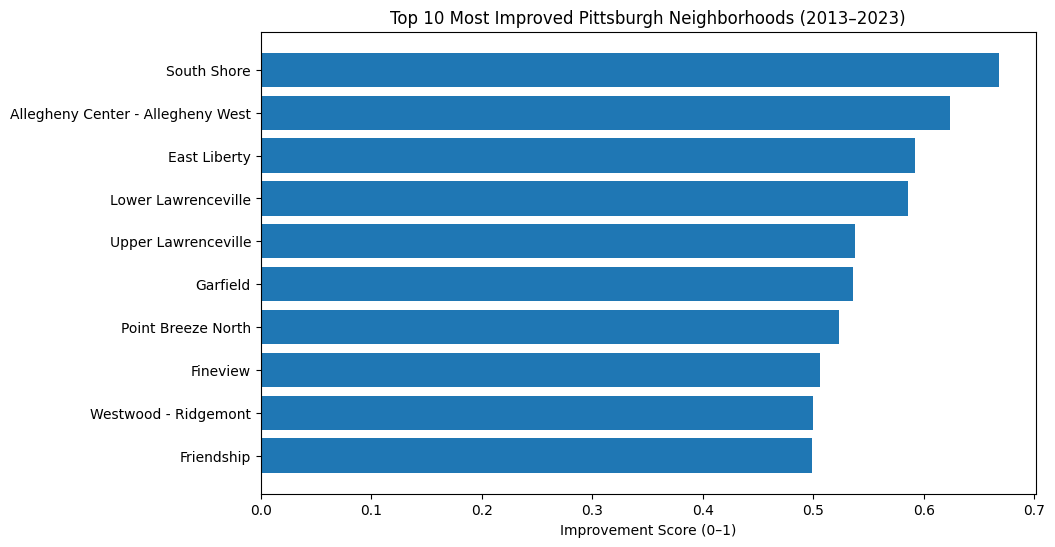

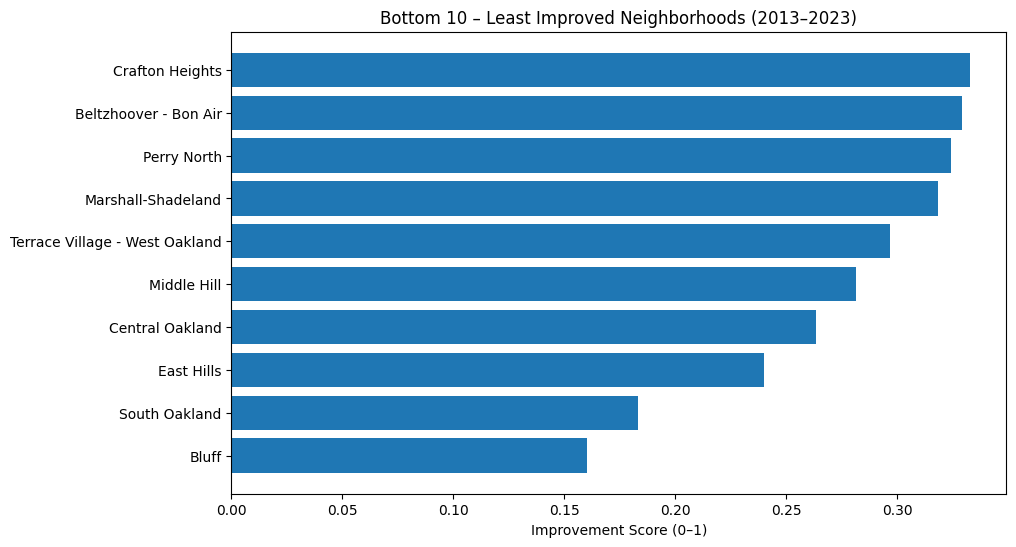

In [15]:
## PLOTS
plt.figure(figsize=(10, 6))
plt.barh(ranking.head(10)["AreaName"], ranking.head(10)["overall_improvement"])
plt.gca().invert_yaxis()
plt.title("Top 10 Most Improved Pittsburgh Neighborhoods (2013–2023)")
plt.xlabel("Improvement Score (0–1)")
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(ranking.tail(10)["AreaName"], ranking.tail(10)["overall_improvement"])
plt.gca().invert_yaxis()
plt.title("Bottom 10 – Least Improved Neighborhoods (2013–2023)")
plt.xlabel("Improvement Score (0–1)")
plt.show()